# RFM 분석
- RFM 고객 분석하기 위한 피처를 R,F,M 피처를 가지고 고객을 이해하고, 고객을 분석하자라는 분석 방법론
- R : Recency : 고객 중 가장 최근 구매한 상품 구입일과 현재 기준까지의 기간 
- F : Frequency : 상품 구매 횟수, 주문 횟수 ( 기준에 따라 다르다. )
- M : Monetary : 고객의 총 주문 금액
---
- 기준을 잘 정해야 한다. 
- 도메인에 따라 조금씩 바뀔 수 있다.
- RFM 피처 외에 추가적인 더해서 분석할 수 있다. 
- 쿠폰에 대한 사용, 고객의 불만율, 고객의 다양한 제품 구매, 고객의 지속기간, 손익 등 피처로 추가해서
- 4개의 피처로도 분석이 가능하다. 

## ***Online_Retail 데이터 RFM 군집분석*** 
-----
- 1.1 기존 데이터의 EDA를 통해 피처들간의 시각화, 통계치 등 분석, 인사이트 정리
    - 원본 데이터에 대한 분석
    
- 1.2 RFM 피처를 만들기 위한 기준을 각자 정해서 기준점 코드로 데이터 전처리
    - e.g. 반품은 제외하거나 , 영국 고객만 분석하거나, 비회원은 제외하거나 등등
- 1.3 RFM 피처를 만들어서 실제 통계치로 비교해 보기 

- 1.4 RFM 피처를 통해 군집화 진행 
    - 우리가 배운 KMeans를 통해 군집화 진행 
    - 최적의 군집이 몇 이고? 그런 근거들을 코드와 시각화를 통해 정리
    
- 1.5 RFM 피처에 군집된 label 원본데이터 붙이기 
    - 전체 데이터셋에 label이 형성될 것 
    
- 1.6 RFM 피처를 이용하여 붙인 label로 다른 피처들 분석하기 
    - e.g. 이 고객군들의 주문 제품들은 무엇인지?
    - 시계열 적으로 볼 때 고객들의 주문 패턴등은 어떤 식으로?
    - Description에 대한 추가 분석 등을 조금 더 진행하시면 됩니다.
    
- 1.7 해당 데이터셋의 고객군들의 RFM 지표의 기초통계치를 정리하고, 시각화를 통해 군집들의 기초통계치 ( 군집들의 RFM 지표를 같이 정리 )
    - 전체 RFM 지표의 통계치
    - 우리가 군집한 군집들의 RFM 지표 통계치 
    - 통계치는 (평균, 중앙값, 표준편차, 최빈값 등등 )

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# 클러스터링
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
retail_df=pd.read_excel(io='data/online_retail_II.xlsx')

In [3]:
retail_df.shape

(525461, 8)

In [4]:
retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
retail_df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


### 1. Data Cleaning

In [7]:
df_null = round(100*(retail_df.isnull().sum())/len(retail_df), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.56
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    20.54
Country         0.00
dtype: float64

In [8]:
retail_df['Customer ID'] = retail_df['Customer ID'].astype(str)

### 2.Data Preparation

In [9]:
# 영국 고객만 
retail_sp = retail_df[retail_df['Country'] == 'United Kingdom']
# 취소반품 고객 제외 
retail_sp=retail_sp[retail_sp['Price']>0]
# 주문 취소했으니 주문 수량도 - 인 경우 제외 
retail_sp=retail_sp[retail_sp['Quantity']>0]
# 회원만 추출
retail_sp= retail_sp.dropna(subset=['Customer ID'])

In [10]:
retail_sp.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### 3.Feature Generation : RFM -  CustomerID 당 데이터셋 재구성
- R(Recency) : 고객의 마지막 구매 시점
- F(Frequancy) : 구매 빈도 - 고객이 해당 업체에서 얼마나 자주 구매하는지
- M(Menetary) : 얼마나 많이 소비했는가?

In [11]:
#Monetary

retail_sp['Amount'] = retail_sp['Quantity']*retail_sp['Price']
rfm_m = retail_sp.groupby('Customer ID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,Customer ID,Amount
0,12346.0,372.86
1,12608.0,415.79
2,12745.0,723.85
3,12746.0,254.55
4,12747.0,5080.53


In [12]:
# frequency : 각 아이디 당 invoice 개수
rfm_f = retail_sp.groupby('Customer ID')['Invoice'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head()

,Customer ID,Frequency
0,12346.0,33
1,12608.0,16
2,12745.0,22
3,12746.0,17
4,12747.0,154


In [13]:
rfm = pd.merge(rfm_m, rfm_f, on='Customer ID', how='inner')
rfm.head()

,Customer ID,Amount,Frequency
0,12346.0,372.86,33
1,12608.0,415.79,16
2,12745.0,723.85,22
3,12746.0,254.55,17
4,12747.0,5080.53,154


In [14]:
retail_sp['InvoiceDate'] = pd.to_datetime(retail_sp['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [15]:
max_date = max(retail_sp['InvoiceDate'])
max_date

Timestamp('2010-12-09 20:01:00')

In [16]:
retail_sp['Diff'] = max_date - retail_sp['InvoiceDate']
retail_sp.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,Diff
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,373 days 12:16:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,373 days 12:16:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,373 days 12:16:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,373 days 12:16:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,373 days 12:16:00


In [17]:
rfm_p = retail_sp.groupby('Customer ID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,Customer ID,Diff
0,12346.0,164 days 06:08:00
1,12608.0,39 days 09:12:00
2,12745.0,121 days 09:47:00
3,12746.0,175 days 09:20:00
4,12747.0,4 days 04:23:00


In [18]:
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,Customer ID,Diff
0,12346.0,164
1,12608.0,39
2,12745.0,121
3,12746.0,175
4,12747.0,4


In [19]:
# Merge
rfm = pd.merge(rfm, rfm_p, on='Customer ID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,372.86,33,164
1,12608.0,415.79,16,39
2,12745.0,723.85,22,121
3,12746.0,254.55,17,175
4,12747.0,5080.53,154,4


In [20]:
rfm

,CustomerID,Amount,Frequency,Recency
0,12346.0,372.86,33,164
1,12608.0,415.79,16,39
2,12745.0,723.85,22,121
3,12746.0,254.55,17,175
4,12747.0,5080.53,154,4
...,...,...,...,...
3965,18284.0,461.68,28,66
3966,18285.0,427.00,12,295
3967,18286.0,1296.43,67,111
3968,18287.0,2345.71,85,17


### 4. Distribution

#### 4.1. Histplot

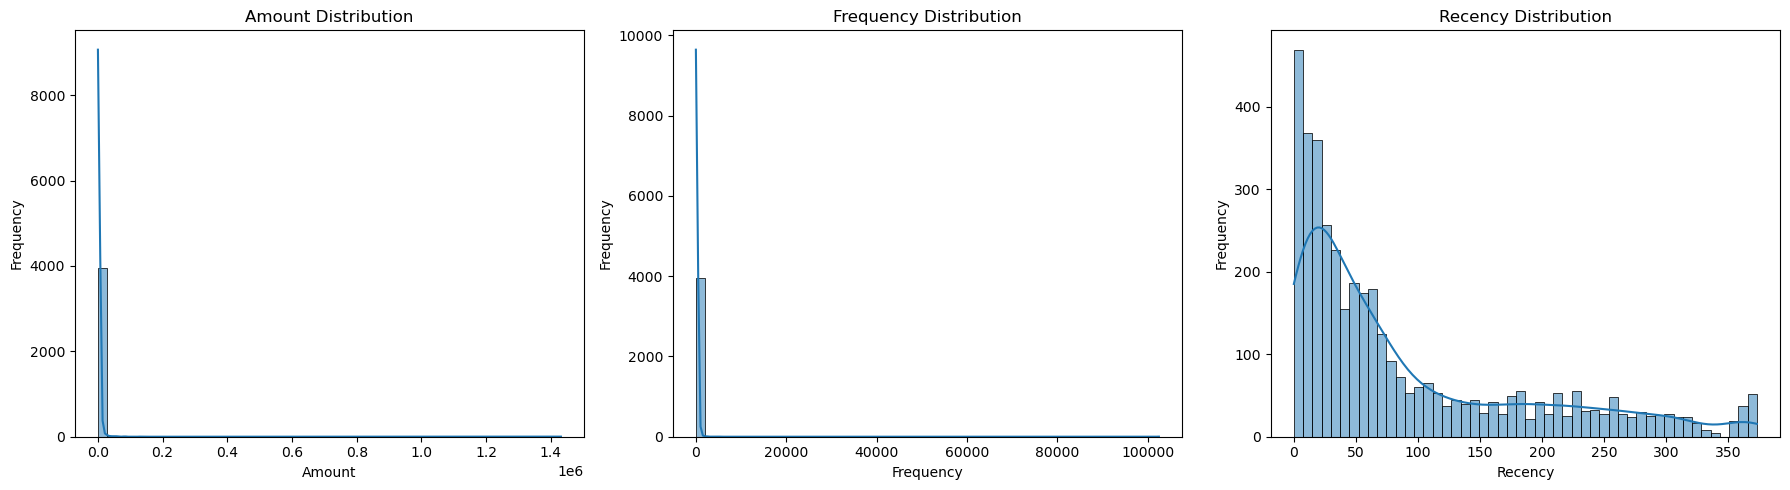

In [21]:
# 수치형 컬럼 리스트
numeric_columns = ['Amount', 'Frequency','Recency']

# 서브플롯 설정
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numeric_columns):
    sns.histplot(rfm[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# 레이아웃 조정
plt.tight_layout()
plt.show()

#### 4.2. Boxplot - Outlier 파악

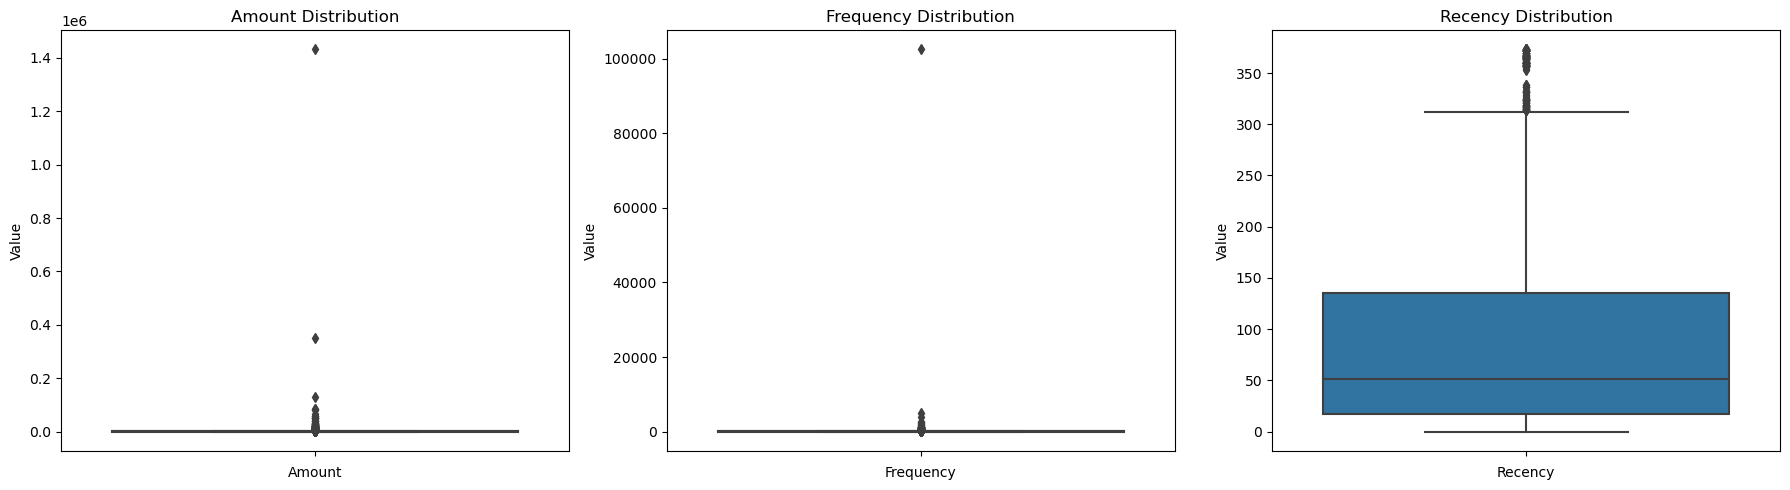

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_columns):
    sns.boxplot(y=rfm[col], ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Value')

# 레이아웃 
plt.tight_layout()
plt.show()

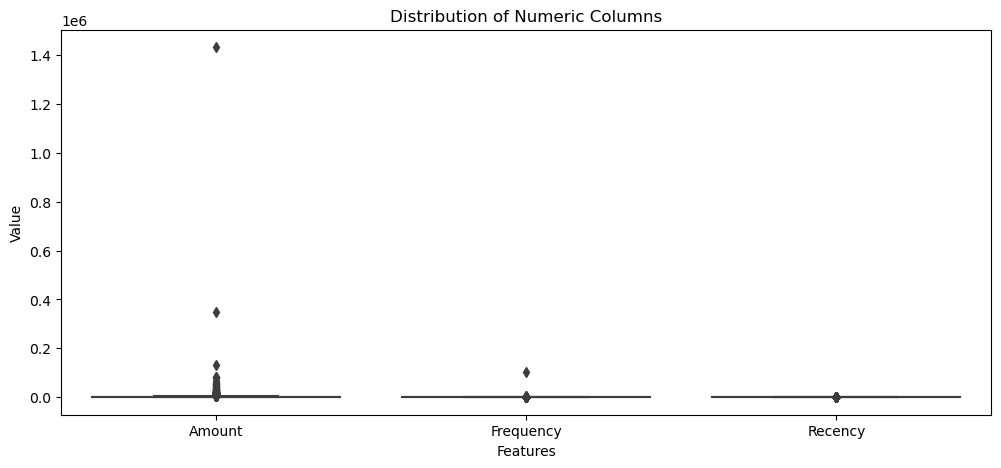

In [23]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=rfm[numeric_columns])
plt.title('Distribution of Numeric Columns')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

이상치 제거하는게 맞는 것일까? > 이상치를 제거하는 것이 더 클러스터링이 잘되는 것을 확인했다.

In [24]:
# Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### 5. Scailing

거리기반 클러스터링 알고리즘 적용 시, 스케일링은 필수이다.
스케일이 다르다면, 특정 피쳐가 클러스터링 알고리즘에 중요하게 인식될 수 있기 때문이다.

- 1. standard Scailing(분포를 옮겨주는게 아니라, 평균을 0으로 맞춰주는 것이라고 생각하면 편하다)
- 2. Min-Max Scailing(최소값 0, 최댓값 1로 옮겨줌)

#### 5.1. Log Transform 후 Standard Scaler

In [25]:
rfm['Amount_log'] = np.log1p(rfm['Amount'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])

# 표준 스케일링을 위해 해당 컬럼만 선택
log_transformed_features = rfm[['Amount_log', 'Frequency_log', 'Recency']]

# 표준 스케일링
scaler = StandardScaler()
rfm_scaled_log_standard = scaler.fit_transform(log_transformed_features)

#### 5.2. Standard Scaler

In [26]:
features = rfm[['Amount','Frequency','Recency']]
scaler = StandardScaler()
rfm_standard = scaler.fit_transform(features)

### 6. Modeling

#### 6.1. Elbow Method

In [27]:
def elbow(df, df_name):
    
    inertia = []
    K = range(1, 11)  # 1부터 10까지

    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++',random_state=42)
        kmeans.fit(rfm_standard)
        inertia.append(kmeans.inertia_)

    # Elbow Method
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method For Optimal k ({df_name})')
    plt.show()

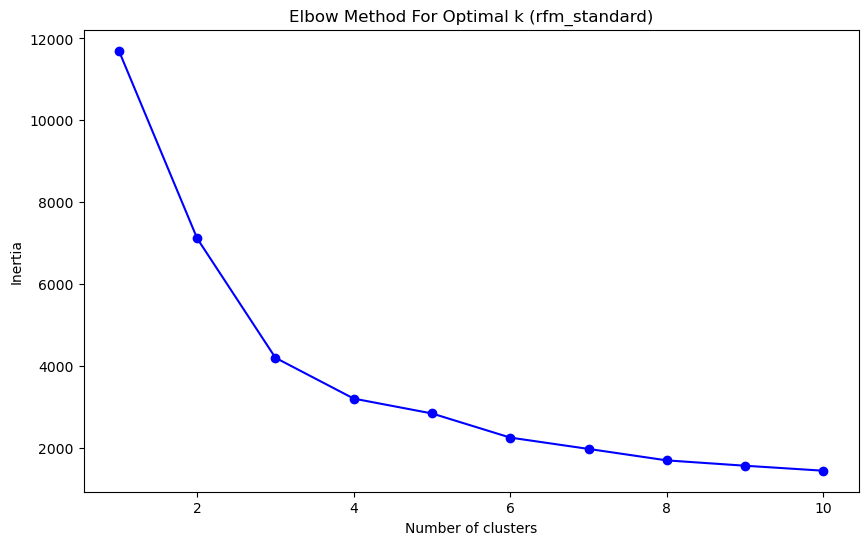

In [28]:
elbow(rfm_standard,"rfm_standard")

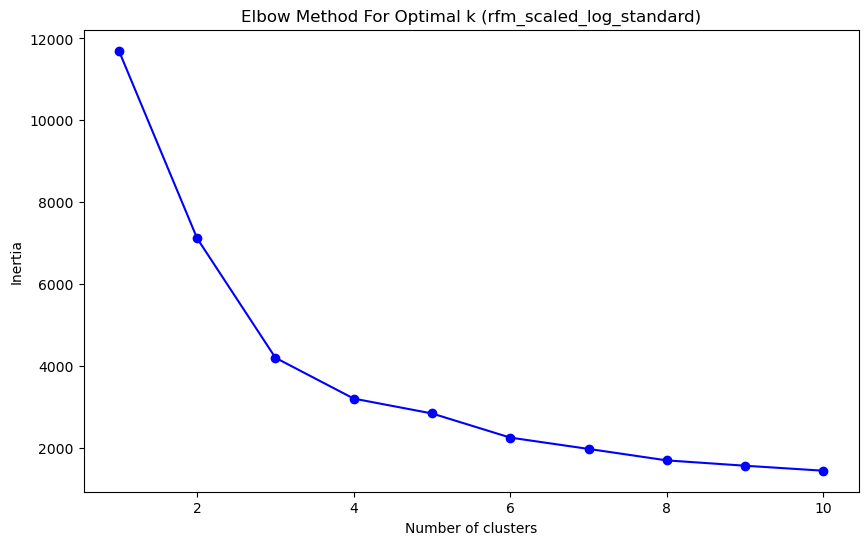

In [29]:
elbow(rfm_scaled_log_standard,"rfm_scaled_log_standard")

In [30]:
# KMeans 클러스터링 (원본 데이터)
kmeans_rfm = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_rfm = kmeans_rfm.fit_predict(rfm[['Amount', 'Frequency', 'Recency']])

rfm['Cluster_rfm'] = clusters_rfm

# KMeans 클러스터링 수행(로그변환 후 표준화)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_log_standard = kmeans.fit_predict(rfm_scaled_log_standard)

# 클러스터 결과를 데이터프레임에 추가
rfm['Cluster_log_standard'] = clusters_log_standard

# KMeans 클러스터링 수행(표준화)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_standard = kmeans.fit_predict(rfm_standard)

# 클러스터 결과를 데이터프레임에 추가
rfm['Cluster_standard'] = clusters_standard

In [31]:
# 3D 시각화 함수 정의
def plot_3d_kmeans_clustering(df, clusters, k, title):
    # 3D 시각화
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 산점도 그리기
    scatter = ax.scatter(df[:, 0], df[:, 1], df[:, 2], c=clusters, cmap='viridis', s=50)

    # 축 라벨 설정
    ax.set_xlabel('Standardized Amount')
    ax.set_ylabel('Standardized Frequency')
    ax.set_zlabel('Standardized Recency')

    # 제목 설정
    ax.set_title(title)

    # 범례 추가
    legend = ax.legend(*scatter.legend_elements(), title='Clusters')
    ax.add_artist(legend)

    plt.show()


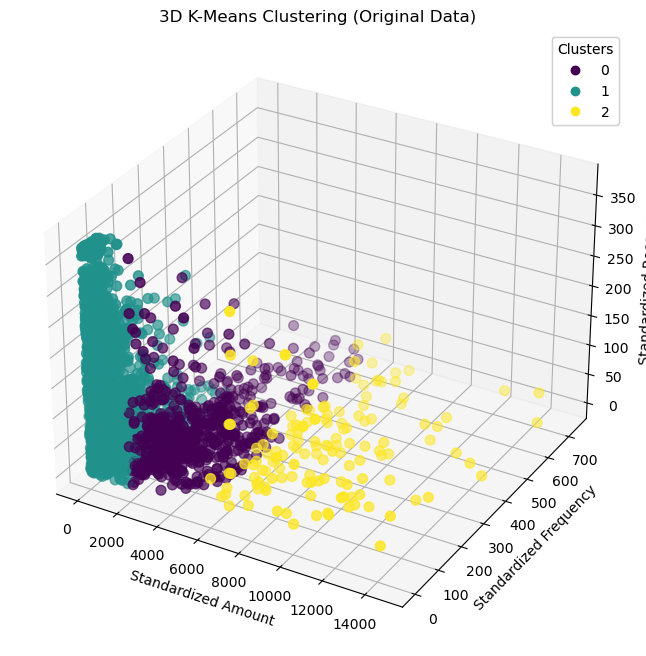

In [32]:
# 원본 데이터에 대한 3D 시각화
rfm_values = rfm[['Amount', 'Frequency', 'Recency']].values
plot_3d_kmeans_clustering(rfm_values, clusters_rfm, 3, '3D K-Means Clustering (Original Data)')

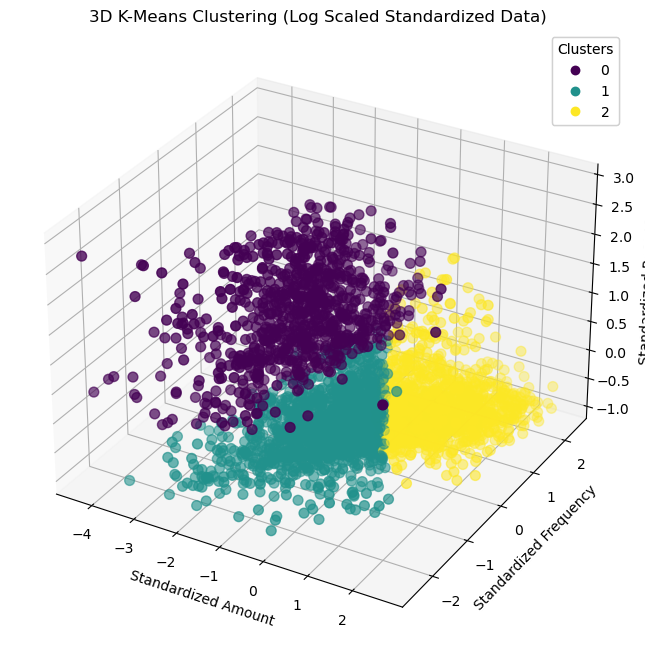

In [33]:
# 함수 호출 (로그 변환 및 표준 스케일링 된 데이터에 대해)
plot_3d_kmeans_clustering(rfm_scaled_log_standard,clusters_log_standard, 3, '3D K-Means Clustering (Log Scaled Standardized Data)')

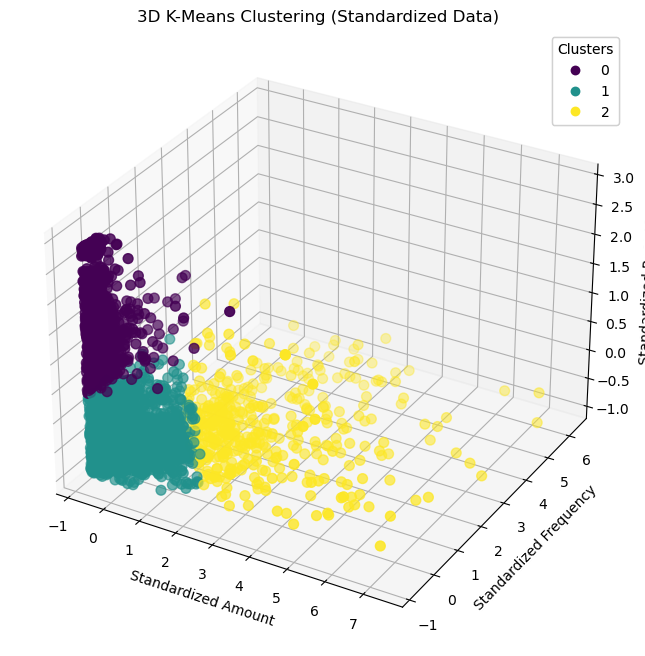

In [34]:
# 함수 호출 (표준 스케일링 된 데이터에 대해)
plot_3d_kmeans_clustering(rfm_standard, clusters_standard, 3, '3D K-Means Clustering (Standardized Data)')

#### 6.2. Silhouette Score

In [35]:
from sklearn.metrics import silhouette_score

# 원본 데이터에 대한 실루엣 계수 계산
silhouette_avg_rfm = silhouette_score(rfm[['Amount', 'Frequency', 'Recency']], clusters_rfm)
print(f"Silhouette Coefficient (Original Data): {silhouette_avg_rfm}")

# 로그 변환 및 표준 스케일링 된 데이터에 대한 실루엣 계수 계산
silhouette_avg_log_standard = silhouette_score(rfm_scaled_log_standard, clusters_log_standard)
print(f"Silhouette Coefficient (Log Scaled Standardized Data): {silhouette_avg_log_standard}")

# 표준 스케일링 된 데이터에 대한 실루엣 계수 계산
silhouette_avg_standard = silhouette_score(rfm_standard, clusters_standard)
print(f"Silhouette Coefficient (Standardized Data): {silhouette_avg_standard}")


Silhouette Coefficient (Original Data): 0.6922638926362148
Silhouette Coefficient (Log Scaled Standardized Data): 0.3861622660558919
Silhouette Coefficient (Standardized Data): 0.5059567289318653


균일한 클러스터링 결과를 가져온 2번째 걸로 진행

In [36]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, init='k-means++',max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()


In [37]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):     
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster,init='k-means++', max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
       
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_19582/1102395678.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_19582/1102395678.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


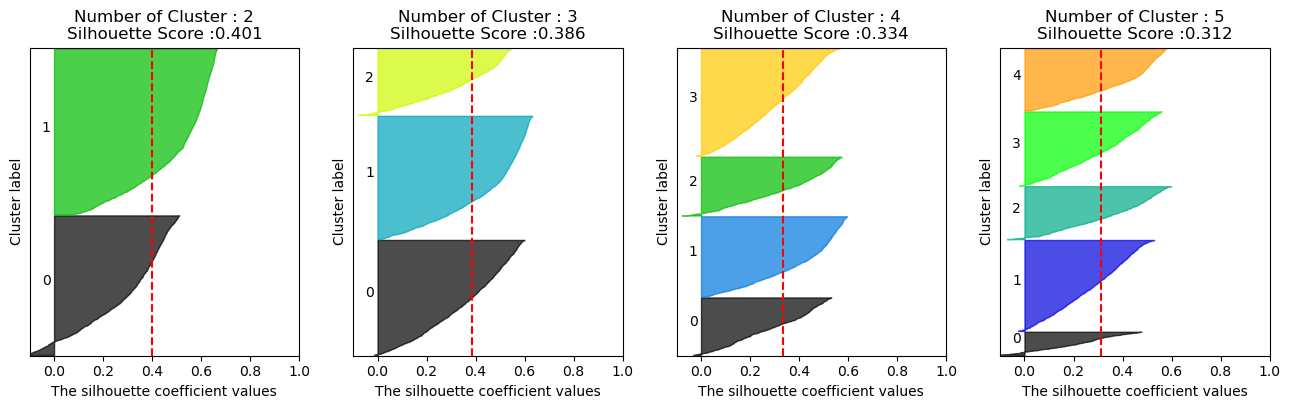

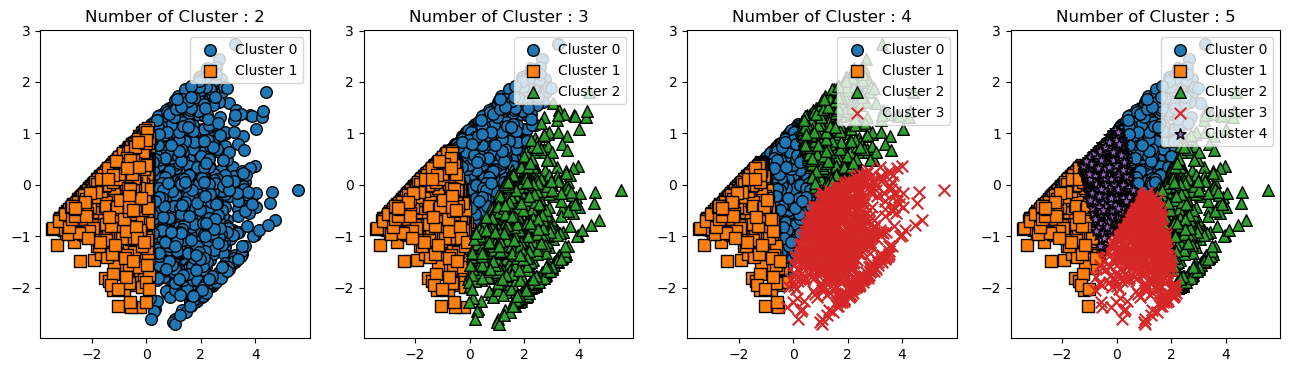

In [38]:
visualize_silhouette([2,3,4,5], rfm_scaled_log_standard)
visualize_kmeans_plot_multi([2,3,4,5],rfm_scaled_log_standard)

/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_19582/1102395678.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_19582/1102395678.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


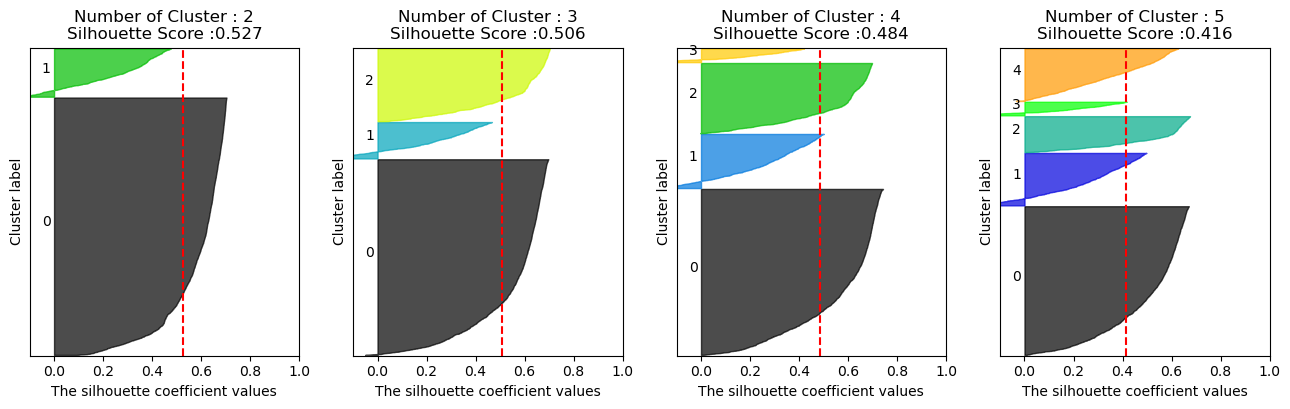

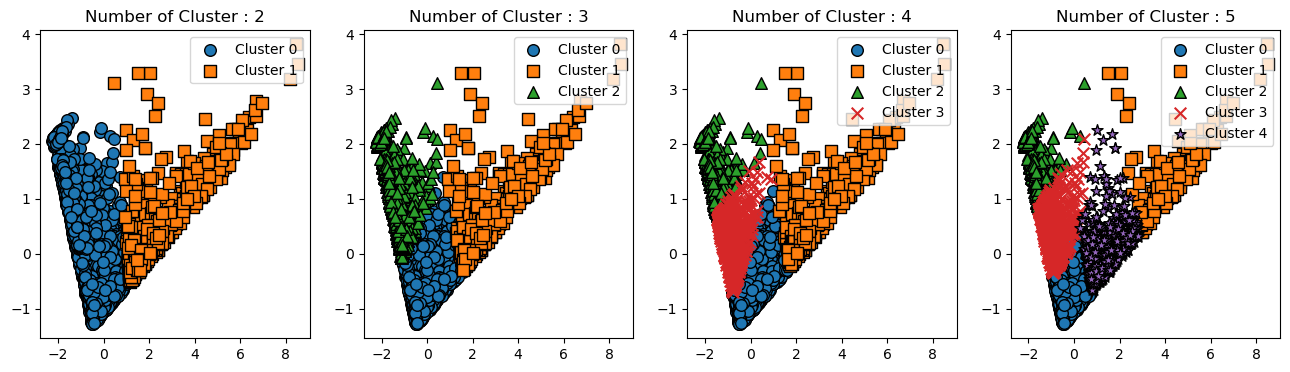

In [39]:
visualize_silhouette([2,3,4,5], rfm_standard)
visualize_kmeans_plot_multi([2,3,4,5],rfm_standard)

### 7. 군집별 분석

#### 7.1 RFM - Descriptive Analysis

In [40]:
rfm_cluster = rfm[['CustomerID','Amount','Frequency','Recency','Cluster_log_standard']]

In [41]:
cluster_summary = rfm_cluster.groupby('Cluster_log_standard').describe()
print(cluster_summary)

                      Amount                                              \
                       count         mean          std     min       25%   
Cluster_log_standard                                                       
0                      847.0   379.207854   632.502994    2.95   147.810   
1                     1472.0   488.731318   404.812654   10.95   236.635   
2                     1581.0  2599.363965  2208.313530  372.22  1219.490   

                                                    Frequency              \
                           50%        75%       max     count        mean   
Cluster_log_standard                                                        
0                      256.600   420.1450  10953.50     847.0   21.763872   
1                      404.905   629.7125   6001.49    1472.0   28.249321   
2                     1890.000  3103.2600  14674.96    1581.0  160.122075   

                      ...               Recency                                \

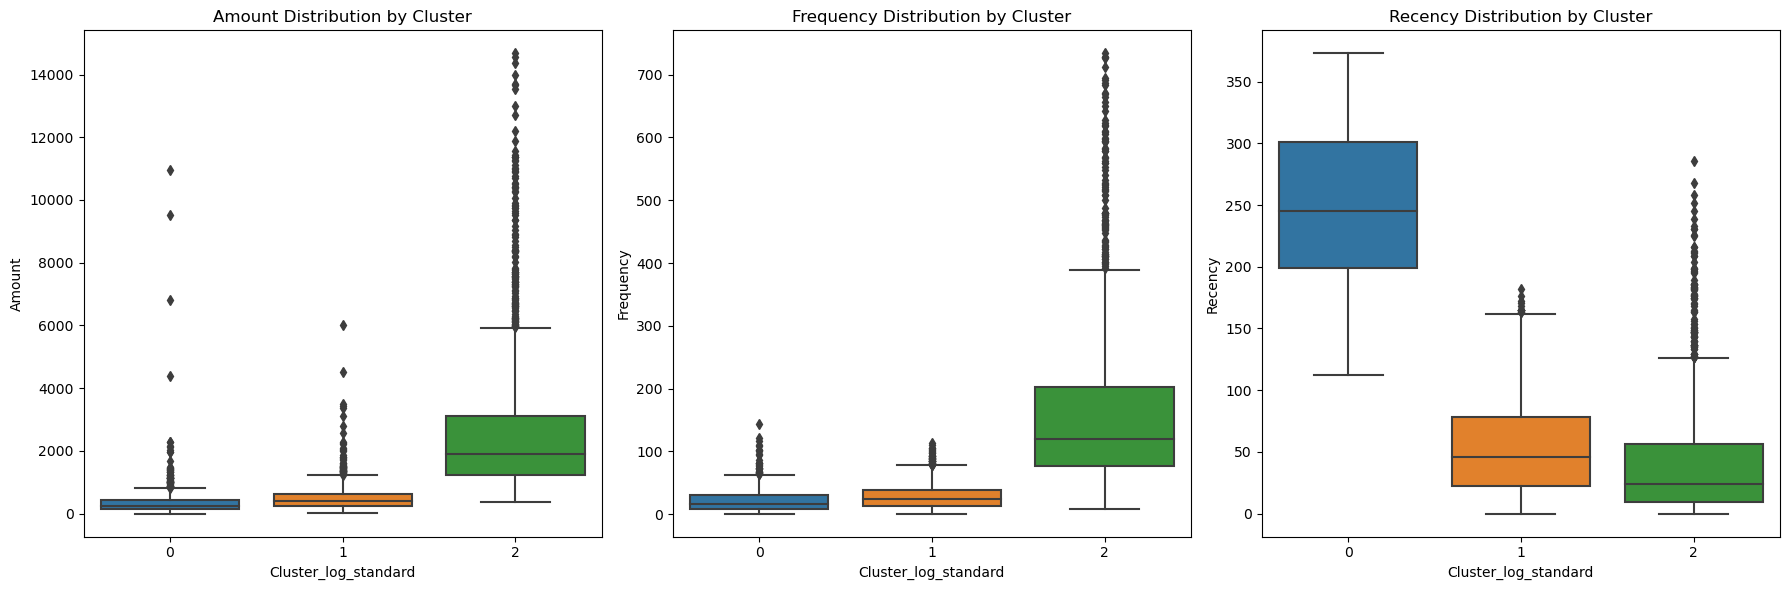

In [42]:
# 군집별 Amount, Frequency, Recency 분포 박스플롯
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Amount 분포 박스플롯
sns.boxplot(x='Cluster_log_standard', y='Amount', data=rfm_cluster, ax=axes[0])
axes[0].set_title('Amount Distribution by Cluster')

# Frequency 분포 박스플롯
sns.boxplot(x='Cluster_log_standard', y='Frequency', data=rfm_cluster, ax=axes[1])
axes[1].set_title('Frequency Distribution by Cluster')

# Recency 분포 박스플롯
sns.boxplot(x='Cluster_log_standard', y='Recency', data=rfm_cluster, ax=axes[2])
axes[2].set_title('Recency Distribution by Cluster')

# 레이아웃 조정
plt.tight_layout()
plt.show()

##### 클러스터 0
- R  : 대부분 오랜 기간 동안 구매하지 않은 고객
- F :고객은 구매 빈도가 낮은 편이며, 일부 고객은 매우 높은 빈도로 구매
- M :비교적 적은 금액을 지출하는 경향이 있으며, 분포가 넓게 퍼져있음

##### 클러스터 1
- R  : 고객은 최근에 구매한 고객이 많으며, 구매 활동이 비교적 활발
- F : 중간 정도의 구매 빈도를 가지며, 일부 고객은 빈번하게 구매
- M :중간 정도의 금액을 지출하며, 지출 금액의 분포는 비교적 고름

##### 클러스터 2
- R  : 최근에 구매한 고객이 많으며, 구매 활동이 매우 활발
- F : 매우 빈번하게 구매하며, 지속적으로 많은 양의 제품을 구매하는 경향
- M :  매우 높은 금액을 지출하며, 지출 금액의 분포가 넓음

#### 7.2. 전체 데이터셋 구성

In [43]:
customer_cluster = rfm[['CustomerID','Cluster_log_standard']]

In [44]:
retail_sp.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Amount', 'Diff'],
      dtype='object')

In [45]:
# 모든 고객 정보를 포함하도록 left join을 사용
retail_df = pd.merge(retail_sp, customer_cluster, left_on='Customer ID', right_on='CustomerID', how='left')

In [46]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473379 entries, 0 to 473378
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   Invoice               473379 non-null  object         
 1   StockCode             473379 non-null  object         
 2   Description           473379 non-null  object         
 3   Quantity              473379 non-null  int64          
 4   InvoiceDate           473379 non-null  datetime64[ns] 
 5   Price                 473379 non-null  float64        
 6   Customer ID           473379 non-null  object         
 7   Country               473379 non-null  object         
 8   Amount                473379 non-null  float64        
 9   Diff                  473379 non-null  timedelta64[ns]
 10  CustomerID            313170 non-null  object         
 11  Cluster_log_standard  313170 non-null  float64        
dtypes: datetime64[ns](1), float64(3), int64(1), 

e.g. 이 고객군들의 주문 제품들은 무엇인지?
    - 시계열 적으로 볼 때 고객들의 주문 패턴등은 어떤 식으로?
    - Description에 대한 추가 분석 등을 조금 더 진행하시면 됩니다.

#### 7.4. 클러스터 별 상위 10개 주문 수량 집계

In [47]:
# 클러스터별로 품목별 주문 수량 집계
cluster_item_summary = retail_df.groupby(['Cluster_log_standard', 'Description']).agg({'Quantity': 'sum'}).reset_index()

# 각 클러스터별로 가장 많이 주문된 상위 10개 품목 추출
top_items_per_cluster = cluster_item_summary.groupby('Cluster_log_standard').apply(lambda x: x.nlargest(10, 'Quantity')).reset_index(drop=True)

# 결과 출력
print(top_items_per_cluster)

    Cluster_log_standard                          Description  Quantity
0                    0.0       STRAWBERRY CERAMIC TRINKET BOX      1867
1                    0.0   WHITE HANGING HEART T-LIGHT HOLDER      1760
2                    0.0     PACK OF 72 RETRO SPOT CAKE CASES      1750
3                    0.0                JASMINE VOTIVE CANDLE      1440
4                    0.0            ASSORTED COLOURS SILK FAN      1434
5                    0.0       HANGING JAM JAR T-LIGHT HOLDER      1384
6                    0.0      BROCADE PURSE,SMALL ARCH BUTTON      1344
7                    0.0        CHINESE DRAGON PAPER LANTERNS      1248
8                    0.0         ASSTD DESIGN BUBBLE GUM RING      1230
9                    0.0          60 TEATIME FAIRY CAKE CASES      1225
10                   1.0          SMALL CHINESE STYLE SCISSOR     15142
11                   1.0                  BROCADE RING PURSE       7227
12                   1.0            ASSORTED COLOURS SILK FAN   

#### 7.5. 월별 주문 패턴 분석

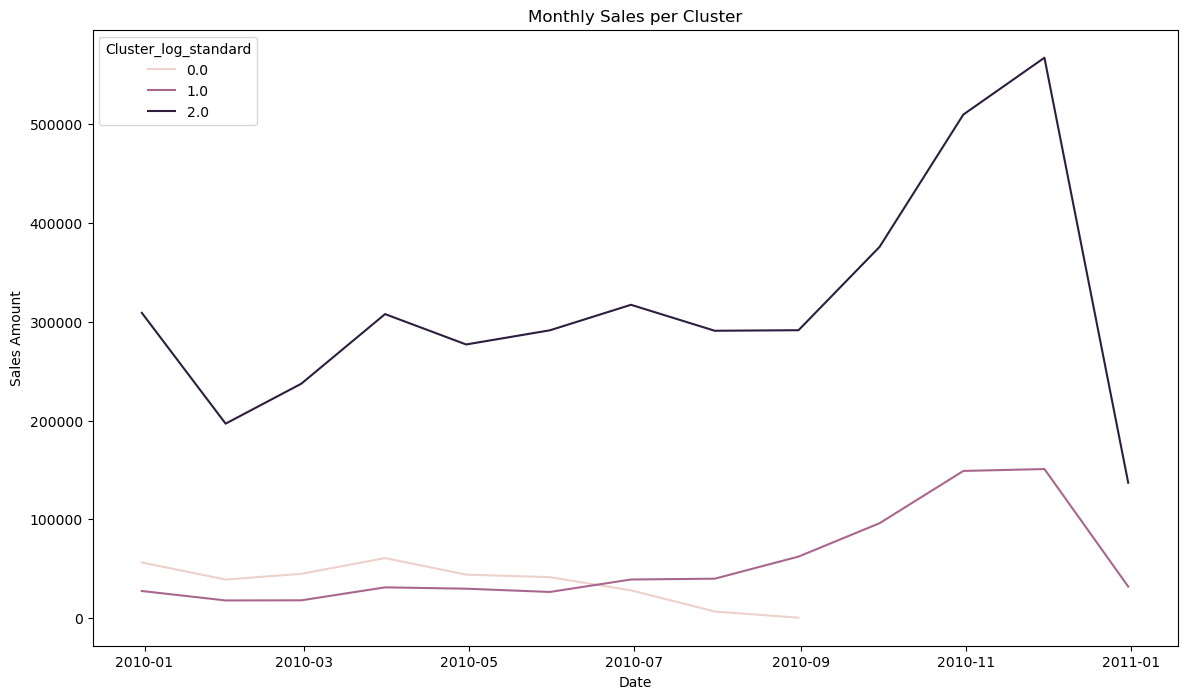

In [48]:
# 클러스터별로 날짜별 주문 금액 집계
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])
retail_df.set_index('InvoiceDate', inplace=True)

# 월별 주문 금액 집계
monthly_sales_per_cluster = retail_df.groupby(['Cluster_log_standard', pd.Grouper(freq='M')])['Amount'].sum().reset_index()

# 시계열적 주문 패턴 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_sales_per_cluster, x='InvoiceDate', y='Amount', hue='Cluster_log_standard')
plt.title('Monthly Sales per Cluster')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.show()


#### 7.5. 시간대별 주문 패턴 분석

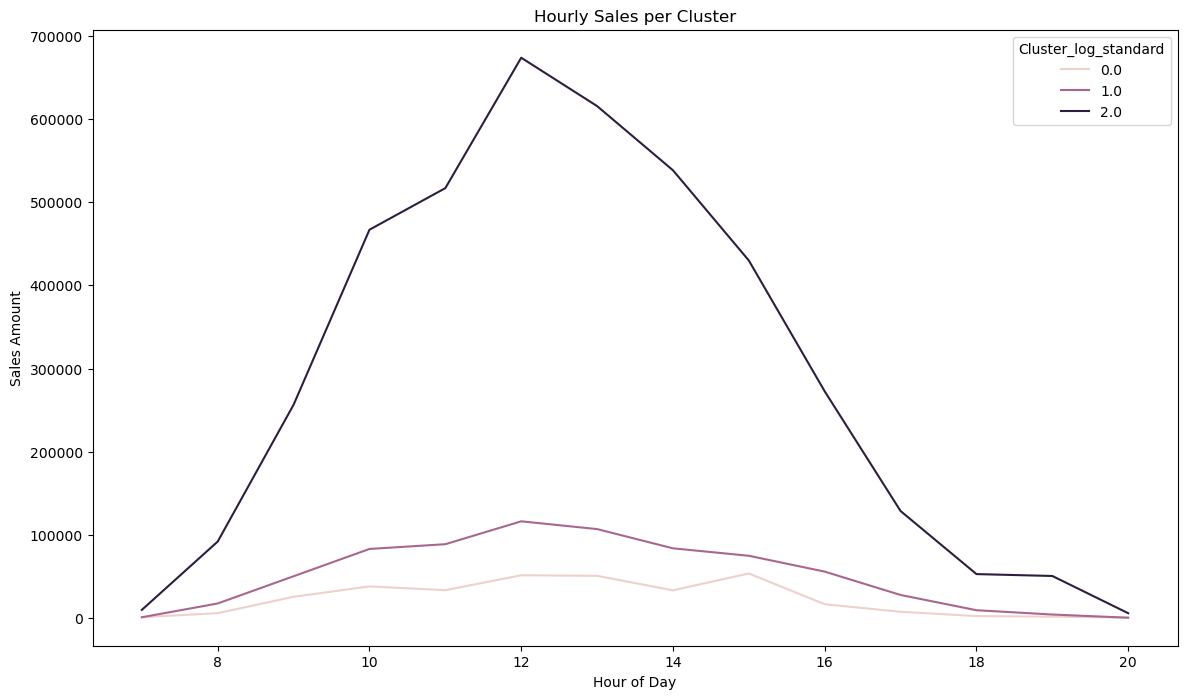

In [49]:
# 시간대별 주문 패턴 분석을 위해 시간 정보 추출
retail_df['Hour'] = retail_df.index.hour

# 클러스터별 시간대별 주문 금액 집계
hourly_sales_per_cluster = retail_df.groupby(['Cluster_log_standard', 'Hour'])['Amount'].sum().reset_index()

# 시간대별 주문 패턴 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=hourly_sales_per_cluster, x='Hour', y='Amount', hue='Cluster_log_standard')
plt.title('Hourly Sales per Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Sales Amount')
plt.show()


### 8. 기술통계 요약

- 전체 기술 통계

In [50]:
print(rfm[['Amount','Frequency','Recency']].describe())

             Amount    Frequency      Recency
count   3900.000000  3900.000000  3900.000000
mean    1320.563072    80.300000    91.433077
std     1800.457547   103.783789    97.340524
min        2.950000     1.000000     0.000000
25%      299.775000    18.000000    18.000000
50%      651.460000    42.000000    52.000000
75%     1575.927500    99.000000   137.000000
max    14674.960000   734.000000   373.000000


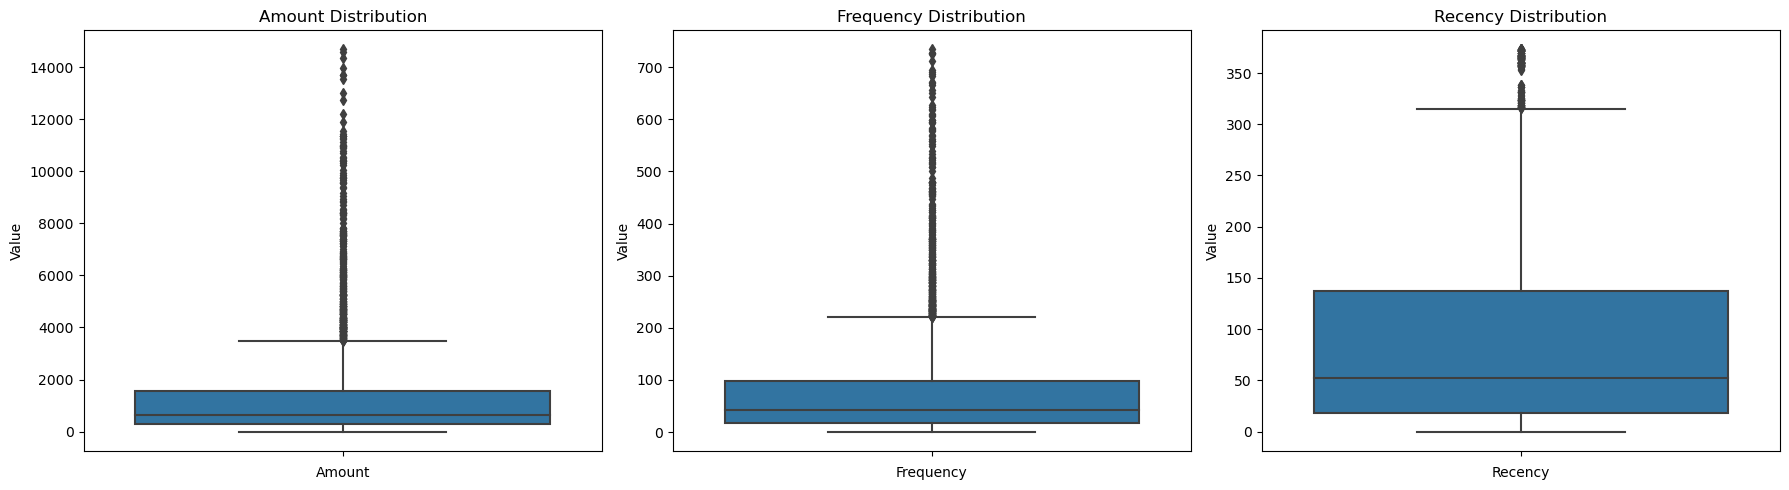

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_columns):
    sns.boxplot(y=rfm[col], ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Value')

# 레이아웃 조정
plt.tight_layout()
plt.show()

In [52]:
cluster_summary = rfm_cluster.groupby('Cluster_log_standard').describe()
print(cluster_summary)

                      Amount                                              \
                       count         mean          std     min       25%   
Cluster_log_standard                                                       
0                      847.0   379.207854   632.502994    2.95   147.810   
1                     1472.0   488.731318   404.812654   10.95   236.635   
2                     1581.0  2599.363965  2208.313530  372.22  1219.490   

                                                    Frequency              \
                           50%        75%       max     count        mean   
Cluster_log_standard                                                        
0                      256.600   420.1450  10953.50     847.0   21.763872   
1                      404.905   629.7125   6001.49    1472.0   28.249321   
2                     1890.000  3103.2600  14674.96    1581.0  160.122075   

                      ...               Recency                                \

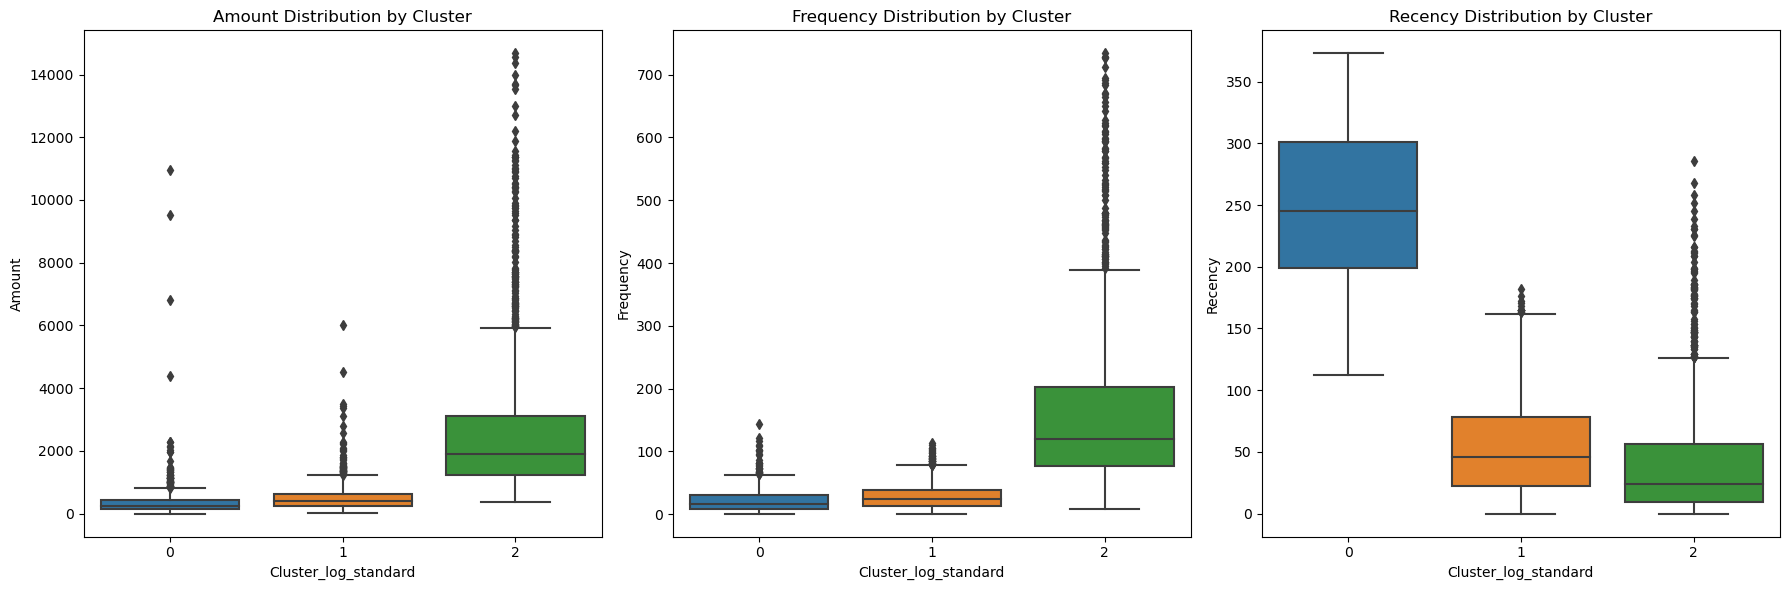

In [53]:
# 군집별 Amount, Frequency, Recency 분포 박스플롯
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Amount 분포 박스플롯
sns.boxplot(x='Cluster_log_standard', y='Amount', data=rfm_cluster, ax=axes[0])
axes[0].set_title('Amount Distribution by Cluster')

# Frequency 분포 박스플롯
sns.boxplot(x='Cluster_log_standard', y='Frequency', data=rfm_cluster, ax=axes[1])
axes[1].set_title('Frequency Distribution by Cluster')

# Recency 분포 박스플롯
sns.boxplot(x='Cluster_log_standard', y='Recency', data=rfm_cluster, ax=axes[2])
axes[2].set_title('Recency Distribution by Cluster')

# 레이아웃 조정
plt.tight_layout()
plt.show()